# Time-Series Classification: Dataset WISDM
_by Mikhail Karasikov_

In [1]:
import numpy as np
import pandas

import timeseries
import feature_extraction

dataset = timeseries.TSDataset()
dataset.load_from_mat('../../data/WISDM/preprocessed_large.mat')
print("Dataset size: %d" % len(dataset))
print("Stats:\n", pandas.DataFrame([ts.shape for ts in dataset.ts],
                                   columns=['dim', 'len']).describe()[1:].round())

Dataset size: 5205
Stats:
       dim  len
mean    3  200
std     0    0
min     3  200
25%     3  200
50%     3  200
75%     3  200
max     3  200


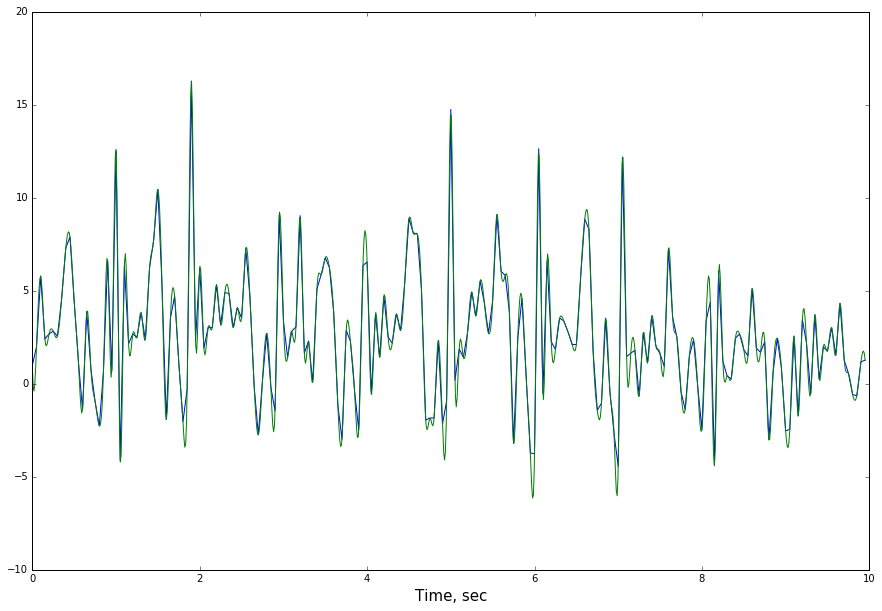

In [4]:
from matplotlib import pylab as plt
%matplotlib inline

x = dataset.ts[5000][0]
t = np.arange(x.size) / 20

freq = 100
t_, x_ = timeseries.transform_frequency(t, x, freq, kind='cubic')

plt.figure(figsize=(15, 10))
plt.plot(t, x)
plt.plot(t_, x_.ravel())
plt.xlabel('Time, sec', size=15)
plt.show()

### Basic Features

In [10]:
X = timeseries.ExtractFeatures(dataset.ts,
    lambda ts: ts.mean(1),
    lambda ts: ts.std(1),
    lambda ts: np.abs(ts - ts.mean(1).reshape(-1, 1)).mean(1),
    lambda ts: np.sqrt((ts ** 2).sum(0)).mean(),
    lambda ts: np.histogram(ts[0], density=True, bins=10)[0] * (ts[0].max() - ts[0].min()) / 10,
    lambda ts: np.histogram(ts[1], density=True, bins=10)[0] * (ts[1].max() - ts[1].min()) / 10,
    lambda ts: np.histogram(ts[2], density=True, bins=10)[0] * (ts[2].max() - ts[2].min()) / 10,
)
X.shape

(5205, 40)

..................................................
Mean accuracy: 0.972612035851
Confusion matrix:
 [[ 1.    0.    0.    0.    0.    0.  ]
 [ 0.    0.99  0.01  0.    0.    0.  ]
 [ 0.03  0.04  0.89  0.04  0.    0.  ]
 [ 0.02  0.05  0.05  0.88  0.    0.  ]
 [ 0.01  0.    0.    0.    0.98  0.  ]
 [ 0.    0.    0.    0.    0.    1.  ]]


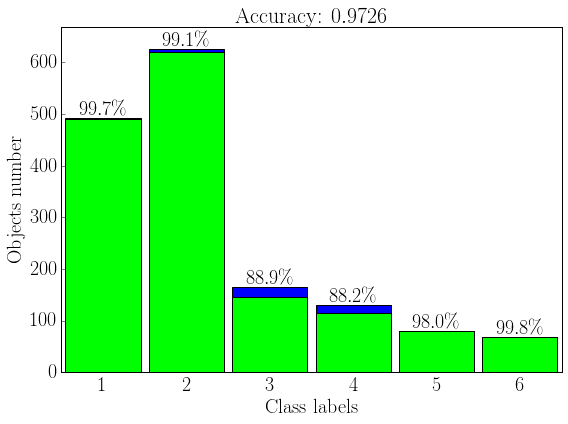

In [11]:
from sklearn import svm, cross_validation
from sklearn.multiclass import OneVsRestClassifier

import multiclass

confusion_mean = multiclass.cross_val_score(
    svm.SVC(gamma=0.12, C=8.5),
    X, dataset.label,
    cross_validation.ShuffleSplit(dataset.label.size, n_iter=50, test_size=0.3, random_state=17)
)

### Basic Features + AR(6) Parameters

In [12]:
X = timeseries.ExtractFeatures(dataset.ts,
   lambda ts: feature_extraction.ar_parameters(ts, np.arange(6) + 1),
   lambda ts: ts.mean(1),
   lambda ts: ts.std(1),
   lambda ts: np.abs(ts - ts.mean(1).reshape(-1, 1)).mean(1),
   lambda ts: np.sqrt((ts ** 2).sum(0)).mean(),
)
X.shape

(5205, 31)

In [13]:
import sklearn.preprocessing

X_normalized = sklearn.preprocessing.MinMaxScaler(feature_range=(-1, 1)).fit_transform(X)

..................................................
Mean accuracy: 0.984583866837
Confusion matrix:
 [[ 1.    0.    0.    0.    0.    0.  ]
 [ 0.    0.99  0.    0.    0.    0.  ]
 [ 0.01  0.02  0.95  0.02  0.    0.  ]
 [ 0.    0.02  0.04  0.94  0.    0.  ]
 [ 0.01  0.    0.    0.    0.97  0.01]
 [ 0.01  0.    0.    0.    0.01  0.97]]


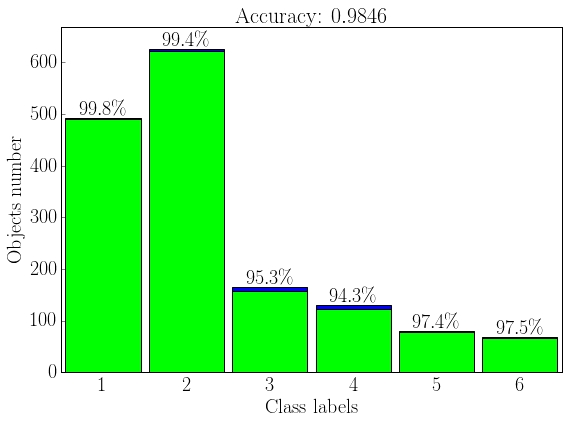

In [14]:
from sklearn.multiclass import OneVsRestClassifier

confusion_mean = multiclass.cross_val_score(
    OneVsRestClassifier(svm.SVC(gamma=0.8, C=8)),
    X_normalized, dataset.label,
    cross_validation.ShuffleSplit(dataset.label.size, n_iter=50, test_size=0.3, random_state=17)
)